# **Homework 3**  - Deep Learning Winter 2024

#  Text Generation & Latent Space Visualization

Student 1: Rajaa Haj 322512690

Student 2: Aseel Shaheen 212393532



In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Part 1 : Song Lyrics Generation**



In [12]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,TensorDataset
from google.colab import files
import os



## *Study the data:*

### Load the CSV:

we will start by loading the Songs CSV file into Dataframe using pandas and showcase a couple of rows from it.





In [4]:
# Load the data from the csv file
data_path='/content/drive/MyDrive/Songs.csv'
data=pd.read_csv(data_path, encoding='utf-8')
data.head(n=10) # Display the first 10 rows of the data

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...
5,Taylor Swift,betty,"Betty, I won't make assumptions\nAbout why you..."
6,Taylor Swift,august,"Salt air, and the rust on your door\nI never n..."
7,Taylor Swift,End Game,I wanna be your end game\nI wanna be your firs...
8,Taylor Swift,You Need To Calm Down,You are somebody that I don't know\nBut you're...
9,Taylor Swift,ME!,I promise that you'll never find another like ...


1) we will print all of the artist's names and show how many songs are associated with each artists

In [5]:
# count the number of songs assoicated for each artist
artist_song_counts=data['Artist'].value_counts()

for artist, count in artist_song_counts.items():

  print(f"{artist}: {count} songs")

Taylor Swift: 50 songs
Billie Eilish: 50 songs
David Bowie: 50 songs
Billy Joel: 50 songs
Eric Clapton: 50 songs
Leonard Cohen: 50 songs
Bruce Springsteen: 40 songs
The Beatles: 35 songs
Vance Joy: 30 songs
Bryan Adams: 30 songs
Lana Del Rey: 30 songs
Nat King Cole: 30 songs
​twenty one pilots: 30 songs
Elton John: 30 songs
Ray LaMontagne: 30 songs
John Denver: 30 songs
Frank Sinatra: 30 songs
George Michael: 30 songs
Queen: 30 songs
Ed Sheeran: 20 songs
Bob Dylan: 20 songs


2)  We will print the size of the dataset and how many songs are there.

In [6]:
data_size=data.shape

print(f"The size of the dataset is {data_size} \n")
print(f"The number of rows in the dataset is {data_size[0]} \n")
print(f"The number of columns in the dataset is {data_size[1]} \n")

songs_num= len(data)

print(f"The number of songs in the dataset is {songs_num}")



The size of the dataset is (745, 3) 

The number of rows in the dataset is 745 

The number of columns in the dataset is 3 

The number of songs in the dataset is 745


3) We will print the average number of characters and words of a song for all songs lyrics in the dataset ( the average length of a song).



In [7]:
total_char=0
total_words=0

for lyrics in data['Lyrics']:
  total_char+=len(lyrics)
  total_words+=len(lyrics.split())

avg_char=total_char/songs_num
avg_word=total_words/songs_num


print(f"The average number of characters per song : {avg_char} \n")
print(f"The average number of words per song : {avg_word} \n")

The average number of characters per song : 1403.3476510067114 

The average number of words per song : 276.26040268456376 



4)  We will print the top 3 most used words in the congs and visualize the data using word cloud image .

The Top 3 most used words is:

the : 8135 times 

i : 6722 times 

you : 6632 times 



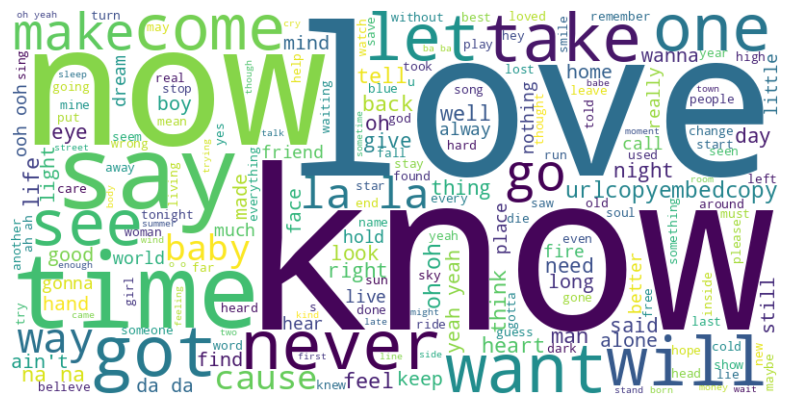

In [8]:

all_lyrics=' '.join(data['Lyrics'].tolist()).lower()
all_words=all_lyrics.split()
words_counts=Counter(all_words)

# get the top 3 used words
top_3_words=words_counts.most_common(3)

# print the top 3 used words
print("The Top 3 most used words is:\n")
for word, count in top_3_words:

  print(f"{word} : {count} times \n")


# Display the word cloud

word_cloud=WordCloud(width=800, height =400 , background_color='white').generate(all_lyrics)

plt.figure(figsize=(10,5))
plt.imshow(word_cloud , interpolation='bilinear')
plt.axis('off')
plt.show()






# *Preprocessing:*



*   we will start by creating a corpus from the given lyrics by extracting the Lyrics column , drop any missing values (using dropna()) and build our corpus from all lyrics .

*   we clean the Corpus from unnecessary symbols and keep only : English letters , numbers , punctuation marks and whitespace .


*   In order to encode the data before training the model :<br>
1) we start by Tokenizing the Text by splitting the cleaned corpus into individual words , then creating a vocabulary dictionary where each word is mapped to unique index . <br>
2) we convert the words to sequences by replacing each word from the vocab with its corresponding numerical index and create a list of numbers to representing all the corpus .








In [9]:
# create the corpus
corpus="\n".join(data["Lyrics"].dropna().astype(str))


# clean the corpus
# keeping only English letters ,digits, punctutaion and whitespace and remove everything else
cleaned_corpus=re.sub(r"[^a-zA-Z0-9.,!?'\s]","" ,corpus)
cleaned_corpus=cleaned_corpus.lower()


#Encode the data
#step 1: Tokenize the text
words= cleaned_corpus.split()
word_counts=Counter(words)
vocab=sorted(word_counts.keys())
word_to_index={ word:i for i, word in enumerate(vocab)}
index_to_word={i: word for word,i in word_to_index.items()}

encoded_corpus=[word_to_index[word] for word in words]


sequence_length=50
step=1
input_sequences=[]
target_sequences=[]

for i in range(0,len(encoded_corpus)-sequence_length,step):
  input_sequences.append(encoded_corpus[i:i+sequence_length])
  target_sequences.append(encoded_corpus[i+sequence_length])







# *Model Definition and training :*

## *Define The Model:*

We will use LSTM model to handle sequential data .
We choose the loss function :
The Optimizer :


In [10]:
class LSTMModel(nn.Module):


  def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128,num_layers=2):

    super(LSTMModel, self).__init__()
    self.embedding=nn.Embedding(vocab_size, embedding_dim)
    self.lstm=nn.LSTM(embedding_dim,hidden_dim,num_layers,batch_first=True)
    self.fc=nn.Linear(hidden_dim,vocab_size)


  def forward(self,x):

    embedded=self.embedding(x)
    lstm_out,_=self.lstm(embedded)
    output=self.fc(lstm_out[:,-1,:])

    return output




## Train the model :

In [13]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# convert to PyTorch tensors
X=torch.tensor(input_sequences, dtype=torch.long)
y=torch.tensor(target_sequences,dtype=torch.long)


batch_size=64
dataset=TensorDataset(X,y)
dataloader=DataLoader(dataset,batch_size=batch_size , shuffle=True )



vocab_size=len(vocab)
model=LSTMModel(vocab_size).to(device)
criterion= nn.CrossEntropyLoss()
learning_rate=0.001
optimizer=optim.Adam(model.parameters(), lr=learning_rate)


model_path='/content/lstm_model.pth'

if os.path.exists(model_path):
  print("loading model....")
  model.load_state_dict(torch.load(model_path))
  model.eval()

else:

  print("training the model ......")

  num_epochs=100
  losses=[]
  for epoch in range(num_epochs):
    total_loss=0
    for batch_X,batch_y in dataloader:
      batch_X,batch_y=batch_X.to(device),batch_y.to(device)
      optimizer.zero_grad()
      outputs=model(batch_X)
      loss=criterion(outputs,batch_y)
      loss.backward()
      optimizer.step()
      total_loss+=loss.item()
    avg_loss=total_loss/len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch[{ epoch+1}/{num_epochs}],Loss: {avg_loss:.4f}")



    # save the trained model
    torch.save(model.state_dict(),model_path)
    files.download(model_path)







training the model ......
Epoch[1/100],Loss: 6.4258


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[2/100],Loss: 5.6840


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[3/100],Loss: 5.2087


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[4/100],Loss: 4.7976


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[5/100],Loss: 4.4381


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[6/100],Loss: 4.1227


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[7/100],Loss: 3.8439


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[8/100],Loss: 3.5965


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[9/100],Loss: 3.3772


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[10/100],Loss: 3.1808


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[11/100],Loss: 3.0065


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[12/100],Loss: 2.8505


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[13/100],Loss: 2.7071


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[14/100],Loss: 2.5775


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[15/100],Loss: 2.4577


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[16/100],Loss: 2.3484


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[17/100],Loss: 2.2461


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[18/100],Loss: 2.1526


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[19/100],Loss: 2.0662


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[20/100],Loss: 1.9842


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[21/100],Loss: 1.9095


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[22/100],Loss: 1.8389


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[23/100],Loss: 1.7743


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[24/100],Loss: 1.7130


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[25/100],Loss: 1.6549


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[26/100],Loss: 1.6026


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[27/100],Loss: 1.5519


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[28/100],Loss: 1.5036


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[29/100],Loss: 1.4603


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[30/100],Loss: 1.4159


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[31/100],Loss: 1.3761


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[32/100],Loss: 1.3405


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[33/100],Loss: 1.3066


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[34/100],Loss: 1.2743


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[35/100],Loss: 1.2407


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[36/100],Loss: 1.2118


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[37/100],Loss: 1.1822


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[38/100],Loss: 1.1561


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[39/100],Loss: 1.1290


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[40/100],Loss: 1.1026


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[41/100],Loss: 1.0803


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[42/100],Loss: 1.0599


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[43/100],Loss: 1.0361


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[44/100],Loss: 1.0200


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[45/100],Loss: 0.9987


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[46/100],Loss: 0.9813


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[47/100],Loss: 0.9641


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[48/100],Loss: 0.9464


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[49/100],Loss: 0.9322


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[50/100],Loss: 0.9134


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[51/100],Loss: 0.9015


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[52/100],Loss: 0.8870


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[53/100],Loss: 0.8742


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[54/100],Loss: 0.8606


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[55/100],Loss: 0.8469


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[56/100],Loss: 0.8389


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[57/100],Loss: 0.8265


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[58/100],Loss: 0.8183


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[59/100],Loss: 0.8051


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[60/100],Loss: 0.7932


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[61/100],Loss: 0.7837


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[62/100],Loss: 0.7761


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[63/100],Loss: 0.7634


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[64/100],Loss: 0.7580


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[65/100],Loss: 0.7476


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[66/100],Loss: 0.7400


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[67/100],Loss: 0.7347


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[68/100],Loss: 0.7230


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[69/100],Loss: 0.7184


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[70/100],Loss: 0.7139


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[71/100],Loss: 0.7098


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[72/100],Loss: 0.6957


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[73/100],Loss: 0.6982


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[74/100],Loss: 0.6826


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[75/100],Loss: 0.6853


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[76/100],Loss: 0.6728


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[77/100],Loss: 0.6651


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[78/100],Loss: 0.6640


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[79/100],Loss: 0.6562


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[80/100],Loss: 0.6537


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[81/100],Loss: 0.6460


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[82/100],Loss: 0.6438


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[83/100],Loss: 0.6404


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[84/100],Loss: 0.6354


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[85/100],Loss: 0.6312


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[86/100],Loss: 0.6245


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[87/100],Loss: 0.6226


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[88/100],Loss: 0.6160


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[89/100],Loss: 0.6131


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[90/100],Loss: 0.6058


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[91/100],Loss: 0.6046


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[92/100],Loss: 0.6033


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[93/100],Loss: 0.5947


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[94/100],Loss: 0.5959


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[95/100],Loss: 0.5919


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[96/100],Loss: 0.5842


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[97/100],Loss: 0.5833


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[98/100],Loss: 0.5837


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[99/100],Loss: 0.5769


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch[100/100],Loss: 0.5735


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

plot

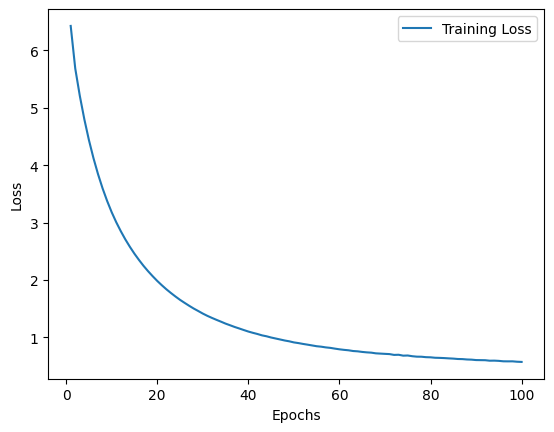

In [14]:
plt.plot(range(1,num_epochs+1) , losses ,label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
def load_trained_model(model_path, vocab_size):

  model=LSTMModel(vocab_size)
  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()
  return model



## **Evaluation:**

In [20]:
def LyricsGenerator(starting_string , char_count):
  model=load_trained_model(model_path,vocab_size)
  #model.eval()
  words=starting_string.split()  ## check if need lower
  generated_lyrics=words[:]


  ## convert words to indx
  input_seq=[word_to_index[word] for word in words if word in word_to_index]
  input_seq=torch.tensor(input_seq,dtype=torch.long).unsqueeze(0).to(device)


  while len(" ".join(generated_lyrics)) < char_count:
    with torch.no_grad():

        output=model(input_seq)
        predicted_index=torch.argmax(output,dim=1).item()
        predicted_word=index_to_word.get(predicted_index,"")
        generated_lyrics.append(predicted_word)

        #update input sequence
        input_seq=torch.cat([input_seq[:,1:], torch.tensor([[predicted_index]],dtype=torch.long).to(device)],dim=1)

    return " ".join(generated_lyrics)




print("Generated Song 1:")
generated_song1=LyricsGenerator("it's not a silly little moment...",avg_char)
print(generated_song1)

# print("\nGenerated Song 2:")
# generated_song2=LyricsGenerator("")


# print("Generated Song 3:")
# generated_song3=LyricsGenerator(" ",avg_char)
# print(generated_song3)







Generated Song 1:
it's not a silly little moment... others


<ipython-input-15-e75809b2dea0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
